In [1]:
import numpy as np
from scipy import misc
from PIL import Image
from math import*
import copy
import matplotlib.pyplot as plt
%matplotlib inline

def get_background(background_height, background_width):
    epsilon_error = 1.0/(256*sqrt(12))
    f = open('backgrounds/backgrounds_to_use.txt')
    splitData = f.read().split("\n")
    curr_num = np.random.randint(len(splitData) - 2) + 1
    img_file = 'backgrounds/'+splitData[curr_num]+'.'+splitData[0]
    curr_img = np.array(Image.open(img_file))
    rows, cols = curr_img.shape
    ul_row = np.random.randint(rows-background_height)
    ul_col = np.random.randint(cols-background_width)
    bg = curr_img[ul_row:ul_row + background_height, ul_col:ul_col + background_width]
    bg1 = copy.deepcopy(bg)
    samplemin = np.min(bg1)
    samplemax = np.max(bg1)
    bg = (bg - samplemin)/(samplemax-samplemin+epsilon_error)
#     plt.imshow(bg)
#     plt.show()
#     ul_img = Image.fromarray(np.uint8(bg))
#     ul_img.show()
    return bg



def add_foreground(background, training_type):  # 01:cat; 02:dog; 03:elephant; 04:pig; 05:truck
    f = open('foregrounds/foregrounds_to_use.txt')
    splitData = f.read().split("\n")
    curr_num = np.random.randint(training_type) + 1
    img_type = curr_num - 1
    img_file = 'foregrounds/'+splitData[curr_num]+'.'+splitData[0] 
    curr_img = Image.open(img_file, 'r')
    fg = np.array(curr_img.convert('L'))
    obj_width, obj_height = fg.shape
    fg1 = copy.deepcopy(fg)
    samplemin = np.min(fg1)
    samplemax = np.max(fg1)
    fg = (fg - samplemin)/(samplemax-samplemin)
#     plt.imshow(fg)
#     plt.show()
    p_r = np.random.randint(5)
    p_c = np.random.randint(5)
    r = (p_r)*2
    c = (p_c)*2
    position = p_r*5+p_c
    background[r:r+obj_width, c:c+obj_width] = fg
#     plt.imshow(background)
#     plt.show()
    return background, img_type, position

def get_image(input_dim, z_neuron_num):
    """
    1: cat; 2:dot; 3:elephant; 4:pig; 5:truck
    position: (row-1)*col
    """
    epsilon_error = 1/(256*sqrt(12))
    background_width = input_dim[0]
    background_height = input_dim[1]
    
    bg = get_background(background_height, background_height)
    
    
    training_type = 1
    if len(z_neuron_num) != 1:
        training_type = z_neuron_num[0]
    
    training_image, img_type, position = add_foreground(bg, training_type)
    true_z = []
    if len(z_neuron_num) != 1:
        true_z.append(img_type)
        true_z.append(position)
    else:
        true_z.append(position)
    true_z = np.array(true_z)
    return training_image, true_z


def preprocess(x):
    x = x - np.mean(x)
    max_val = np.max(x)
    min_val = np.min(x)
    if (max_val - min_val) != 0:
        x = (x - min_val)/(max_val - min_val)
    return x

def compute_response(input_vec, weight_vec, synapse_factor):
    """
    input_vec is of shape 1x input_dim
    weight_vec is of shape input_dim x neuron_num
    syanpse_factor is of shape input_dim x neuron_num
    """
    
    _, neuron_num = weight_vec.shape
    _, input_dim = input_vec.shape
    
    # reshape input to neuron_num x input_dim
    temp_input = np.tile(input_vec, (neuron_num, 1))
    temp_input = temp_input*synapse_factor.T
    
    # normalize input
    temp_input_norm = np.sqrt(np.sum(temp_input*temp_input, axis=1))
    temp_input_norm[temp_input_norm == 0] = 1
    
    temp_input = temp_input/np.tile(temp_input_norm.reshape(-1, 1), (1, input_dim))
    
    # normalize weight
    weight_vec_normalized = weight_vec*synapse_factor
#     plt.imshow(weight_vec_normalized)
#     plt.show()
    weight_vec_norm = np.sqrt(np.sum(weight_vec_normalized*weight_vec_normalized, axis=0))
    weight_vec_norm[weight_vec_norm == 0] = 1
    
    weight_vec_normalized = weight_vec_normalized/np.tile(weight_vec_norm, (input_dim, 1))
    
    output_vec = np.zeros((1, neuron_num))
    for i in range(neuron_num):
        output_vec[0, i] = np.dot(temp_input[i,:].reshape(1, -1), weight_vec_normalized[:, i].reshape(-1, 1))[0,0]
    return output_vec

def top_k_competition(response_input, top_down_response, inhibit_weight, inhibit_synapse_factor, top_k):
    """
    TODO: there are two ways to do things
    1: if a neuron is within the synapse, then include that neuron in top-k
    2: if a neuron is within the synapse and the weight is > 0.5, then
    include that neuron in top-k
    this version does things in the 1st way
    
    response_input is of size 1xneuron_num
    """
    response_output = np.zeros(response_input.shape)
    _, neuron_num = response_input.shape
    top_down_flag = np.ones((1, neuron_num))
    for i in range(len(top_down_response)):
        top_down_flag = top_down_flag*top_down_response[i]
    for i in range(neuron_num):
        curr_response = response_input[0,i]
        curr_mask = (inhibit_synapse_factor[:,i] > 0)
        compare_response = response_input*curr_mask.T.reshape(1, -1)
        compare_response[0,i] = curr_response
        neuron_id = np.argsort(-compare_response.reshape(-1))      
        
        for j in range(top_k):
            if len(top_down_response) != 0:
                if neuron_id[j] == i and top_down_flag[0,i]>0:
                    response_output[0,i] = 1
                    break
            elif neuron_id[j] == i:
                response_output[0,i] = 1
                break            
    return response_output
    
def get_learning_rate(firing_age):
    lr = 1.0/(firing_age+1.0)
    if lr < 1.0/50.0:
        lr = 1.0/50.0
    return lr
        
def get_synapse_factor(synapse_diff, synapse_factor, synapse_coefficient):
    current_diff = synapse_diff
    mean_diff = np.mean(current_diff)
    lower_thresh = synapse_coefficient[0]*mean_diff
    upper_thresh = synapse_coefficient[1]*mean_diff
    
    synapse_factor[synapse_diff > upper_thresh] = 0
    synapse_factor[synapse_diff < lower_thresh] = 1
    
    synapse_factor[((synapse_diff <= upper_thresh)*(synapse_diff >= lower_thresh)) == 1] = ((
        synapse_diff[((synapse_diff <= upper_thresh)*(synapse_diff >= lower_thresh) == 1)] 
        - upper_thresh)/(lower_thresh - upper_thresh))
    return synapse_factor

def check_splitting(firing_age, threshold, percent):
    split_flag = 0
    if np.mean(firing_age > threshold)>(percent/100.0):
        split_flag = 1
    return split_flag

def generate_rand_mutate(random_size):
    rand_vec = np.random.random(random_size) > 0.5
    rand_norm = np.sqrt(np.sum(rand_vec*rand_vec))
    rand_vec = rand_vec/(rand_norm*20.0 + 0.001)
    return rand_vec

In [2]:
class DN:
    def __init__(self, input_dim, y_neuron_num, y_top_k, z_neuron_num):
        self.x_neuron_num = 1
        input_dim = np.array([input_dim]).reshape(-1)
        for i in range(len(input_dim)):
            self.x_neuron_num = self.x_neuron_num*input_dim[i]
        self.y_neuron_num = y_neuron_num
        self.z_area_num = len(z_neuron_num)
        self.z_neuron_num = z_neuron_num
        self.y_top_k = y_top_k
        self.dn_create()
    def dn_create(self):
        self.y_lsn_flag = np.zeros((1, self.y_neuron_num))
        self.y_firing_age = np.zeros((1, self.y_neuron_num))
        self.y_inhibit_age = np.zeros((1, self.y_neuron_num))
        
        self.y_bottom_up_weight = np.ones((self.x_neuron_num, self.y_neuron_num))
        self.y_top_down_weight = []
        for i in range(self.z_area_num):
            self.y_top_down_weight.append(np.ones((self.z_neuron_num[i], self.y_neuron_num)))
        self.y_lateral_weight = np.zeros((self.y_neuron_num, self.y_neuron_num))
        self.y_inhibit_weight = np.ones((self.y_neuron_num, self.y_neuron_num))
        
        self.y_synapse_flag = 1
        """
        1: only bottom-up
        2: bottom-up + top-down
        3: bottom-up + top-down + lateral
        4: bottom-up + top-down + lateral + inhibit
        """
        self.y_synapse_coefficient = [0.8, 1.2, 5.0]
        self.y_synapse_age = 20
        
        self.y_bottom_up_synapse_diff = np.zeros(self.y_bottom_up_weight.shape)
        self.y_bottom_up_synapse_factor = np.ones(self.y_bottom_up_weight.shape)
        
        self.y_top_down_synapse_diff = []
        self.y_top_down_synapse_factor = []
        for i in range(self.z_area_num):
            self.y_top_down_synapse_diff.append(np.zeros(self.y_top_down_weight[i].shape))
            self.y_top_down_synapse_factor.append(np.ones(self.y_top_down_weight[i].shape))
            
        self.y_lateral_synapse_diff = np.zeros(self.y_lateral_weight.shape)
        self.y_lateral_synapse_factor = np.ones(self.y_lateral_weight.shape)
        
        self.y_inhibit_synapse_diff = np.zeros(self.y_inhibit_weight.shape)
        self.y_inhibit_synapse_factor = np.ones(self.y_inhibit_weight.shape)
        
        # z weights
        self.z_bottom_up_weight = []
        self.z_firing_age = []
        for i in range(self.z_area_num):
            self.z_bottom_up_weight.append(np.zeros((self.y_neuron_num, self.z_neuron_num[i])))
            self.z_firing_age.append(np.zeros((1, self.z_neuron_num[i])))
        # responses
        self.x_response = np.zeros((1, self.x_neuron_num))
        # pre lateral response is bottom up + top down, used to get lateral
        # pre response is bottom up + top down + lateral
        self.y_bottom_up_percent = 1/2
        self.y_top_down_percent = 1/2
        self.y_lateral_percent = 1/2
        
        self.y_bottom_up_response = np.zeros((1, self.y_neuron_num))
        self.y_top_down_response = np.zeros((self.z_area_num, self.y_neuron_num))
        self.y_pre_lateral_response = np.zeros((1, self.y_neuron_num))
        self.y_lateral_response = np.zeros((1, self.y_neuron_num))
        self.y_pre_response = np.zeros((1, self.y_neuron_num))
        
        self.y_response = np.zeros((1, self.y_neuron_num))
        self.z_response = []
        for i in range(self.z_area_num):
            self.z_response.append(np.zeros((1, self.z_neuron_num[i])))
    def dn_learn(self, training_image, true_z):
        self.x_response = training_image.reshape(1, -1)
        for i in range(self.z_area_num):
            self.z_response[i] = np.zeros(self.z_response[i].shape)
            self.z_response[i][0,true_z[i]] = 1
        self.x_response = preprocess(self.x_response)
         # compute response
        self.y_bottom_up_response = compute_response(self.x_response, 
                                                     self.y_bottom_up_weight, 
                                                     self.y_bottom_up_synapse_factor)
        for i in range(self.z_area_num):
            self.y_top_down_response[i] = compute_response(self.z_response[i], 
                                                          self.y_top_down_weight[i],
                                                          self.y_top_down_synapse_factor[i])
        # top-down + bottom-up response    
        self.y_pre_lateral_response = (self.y_bottom_up_percent*self.y_bottom_up_response + 
                                       self.y_top_down_percent*np.mean(self.y_top_down_response, axis=0).reshape(1,-1))/(self.y_bottom_up_percent + self.y_top_down_percent)
        

        # 侧边响应    
        self.y_lateral_response = compute_response(self.y_pre_lateral_response,
                                                  self.y_lateral_weight,
                                                  self.y_lateral_synapse_factor)
        self.y_pre_response = ((self.y_bottom_up_percent + self.y_top_down_percent)*self.y_pre_lateral_response + 
                               self.y_lateral_percent*self.y_lateral_response)
        
        self.y_response = top_k_competition(self.y_pre_response,
                                            self.y_top_down_response,
                                            self.y_inhibit_weight,
                                            self.y_inhibit_synapse_factor,
                                            self.y_top_k)
        
        # hebbian learning and synapse maitenance
        for i in range(self.y_neuron_num):
            if self.y_response[0,i] == 1: # firing neuron, currently set response to 1
                if self.y_lsn_flag[0,i] == 0:
                    self.y_lsn_flag[0,i] = 1
                    self.y_firing_age[0,i] = 0
                lr = get_learning_rate(self.y_firing_age[0,i]) # learning rate
                # bottom-up weight and synapse factor
                self.y_bottom_up_weight[:,i] = (1-lr)*self.y_bottom_up_weight[:,i] + lr*self.x_response.reshape(-1)
                self.y_bottom_up_synapse_diff[:,i] = ((1-lr)*self.y_bottom_up_synapse_diff[:,i]+
                                                      lr*(np.abs(self.y_bottom_up_weight[:,i]-self.x_response.reshape(-1))))
                if self.y_synapse_flag>0 and self.y_firing_age[0,i] > self.y_synapse_age:
                    self.y_bottom_up_synapse_factor[:,i] = get_synapse_factor(self.y_bottom_up_synapse_diff[:,i],
                                                                              self.y_bottom_up_synapse_factor[:,i],
                                                                              self.y_synapse_coefficient)
                
                # top-down weight and synapse factor
                for j in range(self.z_area_num):
                    self.y_top_down_weight[j][:,i] = (1-lr)*self.y_top_down_weight[j][:,i] + lr*self.z_response[j].reshape(-1)
                    self.y_top_down_synapse_diff[j][:,i] = ((1-lr)*self.y_top_down_synapse_diff[j][:,i] + 
                                                            lr*np.abs(self.y_top_down_weight[j][:,i]-self.z_response[j].reshape(-1)))
                    if (self.y_synapse_flag>1) and (self.y_firing_age[0,i]>self.y_synapse_age):
                        self.y_top_down_synapse_factor[j][:,i] = get_synapse_factor(self.y_top_down_synapse_diff[j][:,i],
                                                                                    self.y_top_down_synapse_factor[j][:,i],
                                                                                    self.y_synapse_coefficient)
                # lateral weight and synapse factor
                # lateral exitation connection only exists within firing neurons
                self.y_lateral_weight[:,i] = (1-lr)*self.y_lateral_weight[:,i]+lr*self.y_response.reshape(-1)
                self.y_lateral_synapse_diff[:,i] = ((1-lr)*self.y_lateral_synapse_diff[:,i] + 
                                                    lr*np.abs(self.y_lateral_weight[:,i] - self.y_response.reshape(-1)))
                if (self.y_synapse_flag > 2) and (self.y_firing_age[0,i]>self.y_synapse_age):
                    self.y_lateral_synapse_factor[:,i] = get_synapse_factor(self.y_lateral_synapse_diff[:,i],
                                                                           self.y_lateral_synapse_factor[:,i],
                                                                           self.y_synapse_coefficient)
                self.y_firing_age[0,i] = self.y_firing_age[0,i] + 1
            elif self.y_lsn_flag[0,i] == 0: # initialization stage neuron is always updating
                lr = get_learning_rate(self.y_firing_age[0,i])
                normed_input = self.x_response.reshape(-1, 1)*self.y_bottom_up_synapse_factor[:,i].reshape(-1, 1)
                self.y_bottom_up_weight[:,i] = (1-lr)*self.y_bottom_up_weight[:,i]+lr*normed_input.reshape(-1)
                self.y_bottom_up_weight[:,i] = self.y_bottom_up_weight[:,i]*self.y_bottom_up_synapse_factor[:,i]
                self.y_bottom_up_synapse_diff[:,i] = ((1-lr)*self.y_bottom_up_synapse_diff[:,i] +
                                                     lr*np.abs(self.y_bottom_up_weight[:,i] - normed_input.reshape(-1)))
                
                if self.y_synapse_flag>0 and self.y_firing_age[0,i] > self.y_synapse_age:
                    self.y_bottom_up_synapse_factor[:,i] = get_synapse_factor(self.y_bottom_up_synapse_diff[:,i],
                                                                          self.y_bottom_up_synapse_factor[:,i],
                                                                          self.y_synapse_coefficient)  
                # top-down weight and synapse factor
                for j in range(self.z_area_num):
                    self.y_top_down_weight[j][:,i] = (1-lr)*self.y_top_down_weight[j][:,i] + lr*self.z_response[j].reshape(-1)
                    self.y_top_down_synapse_diff[j][:,i] = ((1-lr)*self.y_top_down_synapse_diff[j][:,i] + 
                                                            lr*np.abs(self.y_top_down_weight[j][:,i]-self.z_response[j].reshape(-1)))
                    if (self.y_synapse_flag>1) and (self.y_firing_age[0,i]>self.y_synapse_age):
                        self.y_top_down_synapse_factor[j][:,i] = get_synapse_factor(self.y_top_down_synapse_diff[j][:,i],
                                                                                    self.y_top_down_synapse_factor[j][:,i],
                                                                                    self.y_synapse_coefficient)
                        
                # lateral weight and synapse factor
                # lateral exitation connection only exists within firing neurons
                self.y_lateral_weight[:,i] = (1-lr)*self.y_lateral_weight[:,i]+lr*self.y_response.reshape(-1)
                self.y_lateral_synapse_diff[:,i] = ((1-lr)*self.y_lateral_synapse_diff[:,i] + 
                                                    lr*np.abs(self.y_lateral_weight[:,i] - self.y_response.reshape(-1)))
                if (self.y_synapse_flag > 2) and (self.y_firing_age[0,i]>self.y_synapse_age):
                    self.y_lateral_synapse_factor[:,i] = get_synapse_factor(self.y_lateral_synapse_diff[:,i],
                                                                           self.y_lateral_synapse_factor[:,i],
                                                                           self.y_synapse_coefficient)   
            else:
                lr = get_learning_rate(self.y_inhibit_age[0,i])
                temp = np.zeros(self.y_inhibit_synapse_factor.shape)
                for j in range(self.y_neuron_num):
                    temp[:,j] = self.y_pre_lateral_response.reshape(-1)*self.y_inhibit_synapse_factor[:,j]
                    temp[:,j] = (temp[:,j] > self.y_pre_lateral_response[0,i])
                self.y_inhibit_weight[:,i] = (1-lr)*self.y_inhibit_weight[:,i]+lr*temp[:,i]
                self.y_inhibit_synapse_diff[:,i] = ((1-lr)*self.y_inhibit_synapse_diff[:,i] + 
                                                   lr*np.abs(self.y_inhibit_weight[:,i]-temp[:,i]))
                if (self.y_synapse_flag > 3) and (self.y_firing_age[0,i]>self.y_synapse_age):
                    self.y_inhibit_synapse_factor[:,i] = get_synapse_factor(self.y_inhibit_synapse_diff[:,i],
                                                                           self.y_inhibit_synapse_factor[:,i],
                                                                           self.y_synapse_coefficient)
                self.y_inhibit_age[0,i] = self.y_inhibit_age[0,i] + 1
        ## z neuron learning
        for area_idx in range(self.z_area_num):
            for i in range(self.z_neuron_num[area_idx]):
                if self.z_response[area_idx][0,i] == 1:
                    lr = get_learning_rate(self.z_firing_age[area_idx][0,i])
                    self.z_bottom_up_weight[area_idx][:,i] = (1-lr)*self.z_bottom_up_weight[area_idx][:,i]+lr*self.y_response.reshape(-1)
                    self.z_firing_age[area_idx][0,i] = self.z_firing_age[area_idx][0,i] + 1
    def dn_test(self, test_image):
        self.x_response = test_image.reshape(1, -1)
        self.x_response = preprocess(self.x_response)
        self.y_bottom_up_response = compute_response(self.x_response, 
                                                     self.y_bottom_up_weight, 
                                                     self.y_bottom_up_synapse_factor)
        self.y_pre_lateral_response = self.y_bottom_up_response
        self.y_lateral_response = compute_response(self.y_pre_lateral_response,
                                                   self.y_lateral_weight,
                                                   self.y_lateral_synapse_factor)
        self.y_pre_response = ((self.y_bottom_up_percent*self.y_pre_lateral_response+
                               self.y_lateral_percent*self.y_lateral_response)/(self.y_bottom_up_percent+
                                                                               self.y_lateral_percent))
        self.y_response = top_k_competition(self.y_pre_response, 
                                            [], 
                                            self.y_inhibit_weight, 
                                            self.y_inhibit_synapse_factor, 
                                            self.y_top_k)
        z_output = []
        for i in range(self.z_area_num):
            self.z_response[i] = compute_response(self.y_response,
                                                  self.z_bottom_up_weight[i],
                                                  np.ones(self.z_bottom_up_weight[i].shape))
            z_output_i = np.argmax(self.z_response[i])
            z_output.append(z_output_i)
        return np.array(z_output)
    
def dn_split(dn, split_num, split_firing_age):
    input_dim = dn.x_neuron_num
    y_top_k = dn.y_top_k
    z_neuron_num = dn.z_neuron_num
    y_neuron_num = dn.y_neuron_num*split_num

    new_to_old_index = np.zeros(y_neuron_num, dtype=np.int)
    for i in range(dn.y_neuron_num):
        start_ind = i*split_num
        end_ind = (i+1)*split_num
        new_to_old_index[start_ind:end_ind] = i
    new_to_old_index = new_to_old_index.tolist()
    new_dn = DN(input_dim, y_neuron_num, y_top_k, z_neuron_num)
    for i in range(new_dn.y_neuron_num):
        j = new_to_old_index[i]
        new_dn.y_lsn_flag[0,i] = dn.y_lsn_flag[0,j]
        new_dn.y_firing_age[0,i] = split_firing_age
        new_dn.y_inhibit_age[0,i] = split_firing_age
        
        new_dn.y_bottom_up_weight[:,i] = (dn.y_bottom_up_weight[:,j] + 
                                          generate_rand_mutate(dn.y_bottom_up_weight[:,j].shape))
        new_dn.y_bottom_up_weight[:,i] = (dn.y_bottom_up_weight[:,j])/np.max(new_dn.y_bottom_up_weight[:,j])
        for z_ind in range(new_dn.z_area_num):
            new_dn.y_top_down_weight[z_ind][:,i] = (dn.y_top_down_weight[z_ind][:,j]+
                                                    generate_rand_mutate(dn.y_top_down_weight[z_ind][:,j].shape))
            new_dn.y_top_down_weight[z_ind][:,i] = new_dn.y_top_down_weight[z_ind][:,i]/np.max(new_dn.y_top_down_weight[z_ind][:,i])
        new_dn.y_lateral_weight[:,i] = dn.y_lateral_weight[new_to_old_index, j]
        new_dn.y_inhibit_weight[:,i] = (dn.y_inhibit_weight[new_to_old_index, j]+
                                       generate_rand_mutate(dn.y_inhibit_weight[new_to_old_index, j].shape))
        new_dn.y_inhibit_weight[:,i] = new_dn.y_inhibit_weight[:,i]/np.max(new_dn.y_inhibit_weight[:,i])
        
        new_dn.y_bottom_up_synapse_diff[:,i] = dn.y_bottom_up_synapse_diff[:,j]
        new_dn.y_bottom_up_synapse_factor[:,i] = np.ones(dn.y_bottom_up_synapse_factor[:,j].shape)
        
        for z_ind in range(new_dn.z_area_num):
            new_dn.y_top_down_synapse_diff[z_ind][:,i] = dn.y_top_down_synapse_diff[z_ind][:,j]
            new_dn.y_top_down_synapse_factor[z_ind][:,i] = np.ones(dn.y_top_down_synapse_factor[z_ind][:,j].shape)
        new_dn.y_lateral_synapse_diff[:,i] = dn.y_lateral_synapse_diff[new_to_old_index, j]
        new_dn.y_lateral_synapse_factor[:,i] = np.ones(dn.y_lateral_synapse_factor[new_to_old_index, j].shape)
        
        new_dn.y_inhibit_synapse_diff[:,i] = dn.y_inhibit_synapse_diff[new_to_old_index, j]
        new_dn.y_inhibit_synapse_factor[:,i] = np.ones(dn.y_inhibit_synapse_factor[new_to_old_index,j].shape)
        
        for z_ind in range(new_dn.z_area_num):
            new_dn.z_bottom_up_weight[z_ind][i,:] = dn.z_bottom_up_weight[z_ind][j,:]
            
    for z_ind in range(new_dn.z_area_num):
        new_dn.z_firing_age[z_ind] = np.ones(dn.z_firing_age[z_ind].shape)
    return new_dn
    
    
                


In [ ]:
input_dim = [19, 19]
z_neuron_num = [5, 25]
y_neuron_num = 25
y_top_k = 1

split_percent = 75
split_threshold = 40
split_num = 3
split_firing_age = 0

dn = DN(input_dim, y_neuron_num, y_top_k, z_neuron_num)

training_flag = 1
testing_flag = 1
testing_frequency = 500

training_num = 5*25*200
if training_flag:
    for i in range(training_num):
        training_image, true_z = get_image(input_dim, z_neuron_num)
        dn.dn_learn(training_image, true_z)
        if i%testing_frequency == 0 and i>1:
            testing_num = 500
            error = np.zeros((true_z.shape))
            for j in range(testing_num):
                testing_image, true_z = get_image(input_dim, z_neuron_num)
                z_output = dn.dn_test(testing_image)
#                 print(z_output, true_z)
                error = error + (z_output != true_z)
            print(str(i)+" training, current performance: \n"+str(1.0-error/testing_num))
        if (check_splitting(dn.y_firing_age, split_threshold, split_percent)):
            print("splitting at "+str(i))
            dn = dn_split(dn, split_num, split_firing_age)
            
if testing_flag:
    testing_num = 1000
    error = np.zeros(true_z.shape)
    for i in range(testing_num):
        testing_image, true_z = get_image(input_dim, z_neuron_num)
        z_output = dn.dn_test(testing_image)
        error = error + (z_output != true_z)
print("testing error is "+str(1.0-error/testing_num))


500 training, current performance: 
[0.236 0.078]
1000 training, current performance: 
[0.294 0.086]


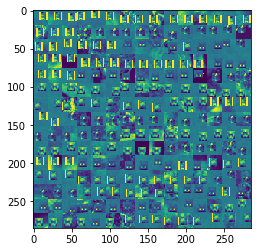

In [7]:
w_mat = np.zeros((15*19, 15*19))
for i in range(dn.y_neuron_num):
    row_i = int(i/15)
    col_i = i%15
    wi = dn.y_bottom_up_weight[:,i].reshape(19, 19)
    w_mat[row_i*19:(row_i+1)*19,col_i*19:(col_i+1)*19] = wi
plt.imshow(w_mat)
plt.savefig('weights.svg', format='svg')
plt.show()
    